In [1]:
### Cell: Imports

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union, Dict
import time

# For inline plots in Jupyter
%matplotlib inline

EPS = 1e-12

In [ ]:
import librosa
import numpy as np
from scipy.signal import gammatone
from typing import List, Tuple

class AudioInput:
    def __init__(self, sample_rate: int = 44100):
        self.sample_rate = sample_rate
        
    def load_audio(self, file_path: str) -> np.ndarray:
        """Load and normalize audio file"""
        audio, sr = librosa.load(file_path, sr=self.sample_rate)
        return audio / np.max(np.abs(audio))

class CochlearFilter:
    def __init__(self, num_bands: int = 64, min_freq: float = 20, max_freq: float = 20000):
        self.num_bands = num_bands
        self.frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_bands)
        
    def create_filterbank(self, sample_rate: int) -> List[np.ndarray]:
        """Create gammatone filterbank"""
        filters = []
        for freq in self.frequencies:
            b = gammatone(freq, sample_rate)
            filters.append(b)
        return filters
    
    def process_signal(self, audio: np.ndarray, sample_rate: int) -> np.ndarray:
        """Split audio into frequency bands"""
        filterbank = self.create_filterbank(sample_rate)
        filtered_signals = np.zeros((self.num_bands, len(audio)))
        
        for i, filt in enumerate(filterbank):
            filtered_signals[i] = np.abs(np.convolve(audio, filt, mode='same'))
            # Normalize each band
            filtered_signals[i] /= np.max(np.abs(filtered_signals[i])) + 1e-6
            
        return filtered_signals

class NeuralPreprocessor:
    def __init__(self, time_window: int = 1000):
        self.time_window = time_window
        
    def prepare_neural_input(self, filtered_signals: np.ndarray) -> List[np.ndarray]:
        """Convert filtered signals to neural input format"""
        num_bands, signal_length = filtered_signals.shape
        neural_inputs = []
        
        for band in range(num_bands):
            # Reshape into time windows
            windows = np.array([filtered_signals[band, i:i+self.time_window] 
                              for i in range(0, signal_length-self.time_window, self.time_window)])
            neural_inputs.append(windows)
            
        return neural_inputs

# Usage example
if __name__ == "__main__":
    audio_processor = AudioInput()
    cochlear = CochlearFilter()
    neural_prep = NeuralPreprocessor()
    
    # Process audio file
    audio = audio_processor.load_audio("input.wav")
    filtered = cochlear.process_signal(audio, audio_processor.sample_rate)
    neural_input = neural_prep.prepare_neural_input(filtered)

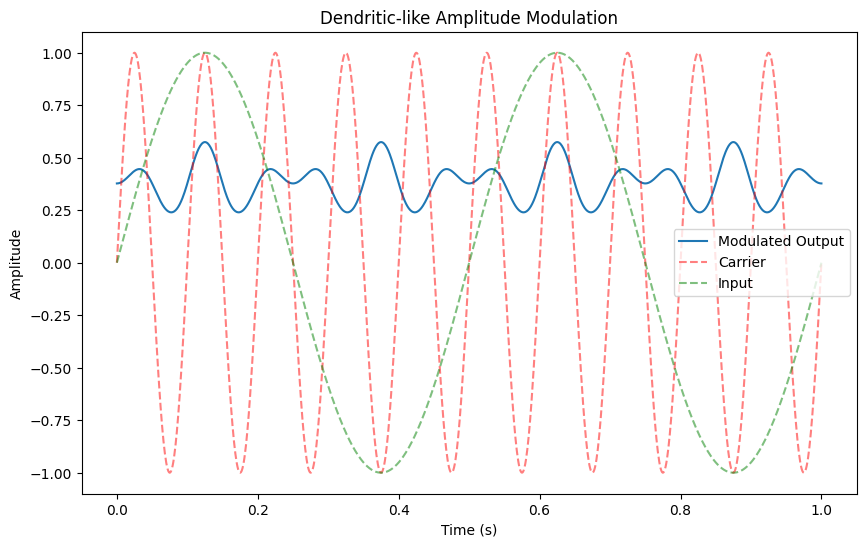


Final states after 10 steps:
[[ 0.79676517 -0.38304123 -0.45241968  0.11730774]
 [ 0.95409492 -0.10081132 -0.26148301 -0.10567213]
 [ 0.97699637  0.07588459 -0.09381652 -0.1758354 ]]


In [12]:
import numpy as np
from dataclasses import dataclass
from typing import List, Optional

EPS = 1e-12

############################################################
# 1. Resonant Partial Interference (Optional)
############################################################
def partial_interference_sphere_resonant(
    base: np.ndarray,
    new: np.ndarray,
    alpha: float = 1.0,
    resonance_gain: float = 0.3
) -> np.ndarray:
    """
    A resonant version of partial_interference_sphere that includes 
    a phase-sensitive gain factor. In-phase waves get amplified, 
    out-of-phase waves get damped.
    
    Steps:
      1) Standard partial interference on the 4D sphere
      2) Multiply the result by a gain_factor = (1 + resonance_gain * dot),
         clamped [0.5..2.0], to emphasize in-phase signals
      3) Re-normalize
    """
    def normalize_4d(vec):
        norm = np.linalg.norm(vec)
        if norm < EPS:
            return np.array([1.0, 0.0, 0.0, 0.0])
        return vec / norm
    
    p_n = normalize_4d(base)
    q_n = normalize_4d(new)
    
    dot_ = np.clip(np.dot(p_n, q_n), -1.0, 1.0)
    angle = np.arccos(dot_)
    
    if angle < EPS:
        return p_n

    # Standard rotation on the sphere
    perp = q_n - dot_ * p_n
    perp_norm = np.linalg.norm(perp)
    if perp_norm < EPS:
        return p_n

    dir_ = perp / perp_norm
    v_scaled = alpha * angle * dir_
    norm_v = np.linalg.norm(v_scaled)
    if norm_v < EPS:
        return p_n

    new_point = (np.cos(norm_v) * p_n 
                 + np.sin(norm_v) * (v_scaled / norm_v))

    # Apply resonance-based gain
    gain_factor = 1.0 + resonance_gain * dot_
    gain_factor = np.clip(gain_factor, 0.5, 2.0)
    new_point *= gain_factor

    return normalize_4d(new_point)

############################################################
# 2. Standard Partial Interference (Non-Resonant)
############################################################
def partial_interference_sphere(base: np.ndarray, new: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    """
    Original partial interference on the 4D hypersphere without resonance.
    """
    def normalize_4d(vec):
        norm = np.linalg.norm(vec)
        if norm < EPS:
            return np.array([1.0, 0.0, 0.0, 0.0])
        return vec / norm
    
    p_n = normalize_4d(base)
    q_n = normalize_4d(new)
    dot_ = np.clip(np.dot(p_n, q_n), -1.0, 1.0)
    angle = np.arccos(dot_)

    if angle < EPS:
        return p_n
    
    perp = q_n - dot_ * p_n
    perp_norm = np.linalg.norm(perp)
    if perp_norm < EPS:
        return p_n
    
    dir_ = perp / perp_norm
    v_scaled = alpha * angle * dir_
    norm_v = np.linalg.norm(v_scaled)
    if norm_v < EPS:
        return p_n
    
    new_point = np.cos(norm_v) * p_n + np.sin(norm_v) * (v_scaled / norm_v)
    return normalize_4d(new_point)

import numpy as np
import matplotlib.pyplot as plt

class DendriticModulation:
    def __init__(self, threshold=0.5, coupling_strength=0.8):
        self.threshold = threshold
        self.coupling = coupling_strength
    
    def nonlinear_response(self, input_signal):
        # Sigmoid-like nonlinear response similar to Purkinje dendrites
        return 1 / (1 + np.exp(-(input_signal - self.threshold)))
    
    def modulate(self, carrier_wave, input_signal):
        # Combine signals with dendritic-like nonlinearity
        interference = self.coupling * carrier_wave * input_signal
        modulated = self.nonlinear_response(interference)
        return modulated

# Generate test signals
t = np.linspace(0, 1, 1000)
carrier = np.sin(2 * np.pi * 10 * t)  # 10Hz carrier
input_wave = np.sin(2 * np.pi * 2 * t)  # 2Hz input

# Create modulator and process signals
modulator = DendriticModulation()
output = modulator.modulate(carrier, input_wave)

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(t, output, label='Modulated Output')
plt.plot(t, carrier, 'r--', alpha=0.5, label='Carrier')
plt.plot(t, input_wave, 'g--', alpha=0.5, label='Input')
plt.legend()
plt.title('Dendritic-like Amplitude Modulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

############################################################
# 3. WaveSphere Class (fast/slow states + optional resonance)
############################################################
class WaveSphere:
    """
    A single 'neuron-like' wave sphere with:
      - fast_state: quick timescale
      - slow_state: slower amplitude memory
      - optional resonance_gain for in-phase amplification on inputs
    """

    def __init__(self, 
                 fast_alpha=0.8, 
                 slow_alpha=0.2, 
                 noise_std=0.0, 
                 resonance_gain=0.0):
        self.fast_alpha = fast_alpha
        self.slow_alpha = slow_alpha
        self.noise_std = noise_std
        self.resonance_gain = resonance_gain
        self.reset()
    
    def reset(self) -> None:
        self.fast_state = np.array([1.0, 0.0, 0.0, 0.0])
        self.slow_state = np.array([1.0, 0.0, 0.0, 0.0])

    @staticmethod
    def normalize_sphere_4d(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm < EPS:
            return np.array([1.0, 0.0, 0.0, 0.0])
        return vec / norm

    def inject_random_spike(self, amplitude=1.0) -> None:
        """
        Inject random noise into fast_state if noise_std > 0
        """
        if self.noise_std >= EPS:
            rnd = np.random.randn(4) * self.noise_std * amplitude
            spike_target = WaveSphere.normalize_sphere_4d(rnd)
            self.fast_state = partial_interference_sphere(
                self.fast_state, spike_target, alpha=0.5
            )

    def update_with_input(self, input_wave: np.ndarray, gating=True) -> None:
        """
        Merge input_wave with fast and slow states. If resonance_gain > 0,
        use partial_interference_sphere_resonant for an in-phase boost.
        """
        if not gating:
            return
        
        if self.resonance_gain > 0.0:
            # Resonant approach
            self.fast_state = partial_interference_sphere_resonant(
                self.fast_state, 
                input_wave, 
                alpha=self.fast_alpha,
                resonance_gain=self.resonance_gain
            )
            self.slow_state = partial_interference_sphere_resonant(
                self.slow_state, 
                input_wave, 
                alpha=self.slow_alpha,
                resonance_gain=self.resonance_gain
            )
        else:
            # Standard partial interference
            self.fast_state = partial_interference_sphere(
                self.fast_state, 
                input_wave,
                alpha=self.fast_alpha
            )
            self.slow_state = partial_interference_sphere(
                self.slow_state, 
                input_wave,
                alpha=self.slow_alpha
            )

    def combine_states(self) -> np.ndarray:
        """
        Merge fast & slow states for final output. Typically non-resonant here,
        but you could swap in resonant if you want.
        """
        return partial_interference_sphere(self.fast_state, self.slow_state, alpha=0.5)

############################################################
# 4. Data class for neighbor overlaps
############################################################
@dataclass
class SphereOverlap:
    idx_A: int
    idx_B: int
    reflection_coeff: float
    transmission_coeff: float

############################################################
# 5. MultiSphereWaveModel
############################################################
class MultiSphereWaveModel:
    """
    Attributes:
    -----------
    M : int
        Number of spheres in the model.
    noisy_indices : list
        Indices of spheres where noise is injected.
    spheres : list
        List of WaveSphere objects representing each sphere.
    overlaps : list
        List of SphereOverlap objects representing the overlaps between neighboring spheres.
    Methods:
    --------
    __init__(M=3, reflection=0.2, transmission=0.7, noise_std=0.0, resonance_gain=0.0, noisy_indices=None):
        Initializes the MultiSphereWaveModel with given parameters.
    set_initial_state(idx, fast_vec, slow_vec=None):
    _process_boundary_interactions(new_fast, new_slow):
    step(input_waves=None, gating_flags=None):
        One step of wave propagation.
    run(steps=10, input_waves_seq=None, gating_seq=None):
    
    A multi-sphere wave memory model. 
    We can:
     - Only inject noise in certain spheres (noisy_indices)
     - Use resonance_gain if we want wave queries to be amplified
     - Perform reflection/transmission among neighbors
    """

    def __init__(self, 
                 M=3, 
                 reflection=0.2, 
                 transmission=0.7, 
                 noise_std=0.0,
                 resonance_gain=0.0,
                 noisy_indices=None):
        self.M = M
        self.noisy_indices = noisy_indices if noisy_indices else []
        
        # Create M spheres
        self.spheres = []
        for i in range(M):
            ns = noise_std if i in self.noisy_indices else 0.0
            sphere = WaveSphere(fast_alpha=0.8,
                                slow_alpha=0.2,
                                noise_std=ns,
                                resonance_gain=resonance_gain)
            self.spheres.append(sphere)

        # Chain-based overlaps
        self.overlaps = [
            SphereOverlap(i, i+1, reflection, transmission)
            for i in range(M-1)
        ]

    def set_initial_state(self, idx, fast_vec, slow_vec=None):
        """
        Initialize a sphere's fast/slow states manually.
        """
        self.spheres[idx].fast_state = WaveSphere.normalize_sphere_4d(np.array(fast_vec, dtype=float))
        if slow_vec is not None:
            self.spheres[idx].slow_state = WaveSphere.normalize_sphere_4d(np.array(slow_vec, dtype=float))

    def _process_boundary_interactions(self, new_fast, new_slow):
        """
        Reflect & transmit neighbor states using standard partial_interference_sphere.
        You could also do resonant interference if you want in-phase neighbor boosting.
        """
        for overlap in self.overlaps:
            iA, iB = overlap.idx_A, overlap.idx_B
            r_coef, t_coef = overlap.reflection_coeff, overlap.transmission_coeff

            dotF = np.clip(np.dot(new_fast[iA], new_fast[iB]), -1.0, 1.0)
            dotS = np.clip(np.dot(new_slow[iA], new_slow[iB]), -1.0, 1.0)

            scaleF = (1.0 - 0.5*abs(dotF)) if dotF < 0 else (1.0 + 0.2*dotF)
            scaleS = (1.0 - 0.5*abs(dotS)) if dotS < 0 else (1.0 + 0.2*dotS)

            alphas = {
                'fr': np.clip(r_coef * scaleF, 0, 1),
                'ft': np.clip(t_coef * scaleF, 0, 1),
                'sr': np.clip(r_coef * scaleS, 0, 1),
                'st': np.clip(t_coef * scaleS, 0, 1)
            }

            # partial_interference for neighbor merges
            fA_merged = partial_interference_sphere(new_fast[iA], new_fast[iB], alpha=alphas['fr'])
            sA_merged = partial_interference_sphere(new_slow[iA], new_slow[iB], alpha=alphas['sr'])
            fB_merged = partial_interference_sphere(new_fast[iB], new_fast[iA], alpha=alphas['ft'])
            sB_merged = partial_interference_sphere(new_slow[iB], new_slow[iA], alpha=alphas['st'])

            # Then partially merge them back
            new_fast[iA] = partial_interference_sphere(new_fast[iA], fA_merged, alpha=0.5)
            new_slow[iA] = partial_interference_sphere(new_slow[iA], sA_merged, alpha=0.5)
            new_fast[iB] = partial_interference_sphere(new_fast[iB], fB_merged, alpha=0.5)
            new_slow[iB] = partial_interference_sphere(new_slow[iB], sB_merged, alpha=0.5)

        return new_fast, new_slow

    def step(self, input_waves=None, gating_flags=None):
        """
        One step of wave propagation:
         - Only spheres in self.noisy_indices get random spikes
         - Merge with external input if any (resonant if resonance_gain>0)
         - Reflect/transmit among neighbors
         - Return combined states
        """
        input_waves = input_waves or [None]*self.M
        gating_flags = gating_flags or [True]*self.M

        # 1) Noise injection & external input merges
        for i, sphere in enumerate(self.spheres):
            sphere.inject_random_spike(amplitude=1.0)
            if input_waves[i] is not None:
                wave_in = WaveSphere.normalize_sphere_4d(input_waves[i])
                sphere.update_with_input(wave_in, gating=gating_flags[i])

        # 2) Gather fresh states
        new_fast = [s.fast_state.copy() for s in self.spheres]
        new_slow = [s.slow_state.copy() for s in self.spheres]

        # 3) Reflect/transmit among neighbors
        new_fast, new_slow = self._process_boundary_interactions(new_fast, new_slow)

        # 4) Update sphere states
        for i, sphere in enumerate(self.spheres):
            sphere.fast_state = new_fast[i]
            sphere.slow_state = new_slow[i]

        # 5) Return combined states
        return [sphere.combine_states() for sphere in self.spheres]

    def run(self, steps=10, input_waves_seq=None, gating_seq=None):
        """
        Perform multiple time steps, storing final combined states at each step.
        """
        input_waves_seq = input_waves_seq or [[None]*self.M for _ in range(steps)]
        gating_seq = gating_seq or [[True]*self.M for _ in range(steps)]

        history = []
        for t in range(steps):
            outs = self.step(input_waves_seq[t], gating_seq[t])
            history.append(outs)
        return np.array(history)

############################################################
# 6. Demo: Frequency-Based Amplitude Modulation
############################################################

def generate_frequency_wave(t: int, freq: float, amplitude: float = 1.0, phase: float = 0.0) -> np.ndarray:
    """
    Example function to produce a time-varying wave in 4D, 
    based on a single frequency for demonstration.
    
    We make a 4D vector using sin and cos in a simple pattern:
      [ amplitude*sin(freq*t + phase), amplitude*cos(freq*t + phase),
        amplitude*sin(2*freq*t + phase), amplitude*cos(2*freq*t + phase) ]
    Then normalize it to simulate a wave's direction with amplitude mod.
    """
    # In a real system, you might do something more elaborate
    raw_vec = np.array([
        amplitude * np.sin(freq*t + phase),
        amplitude * np.cos(freq*t + phase),
        amplitude * np.sin(2*(freq*t + phase)),
        amplitude * np.cos(2*(freq*t + phase))
    ])
    norm = np.linalg.norm(raw_vec)
    if norm < EPS:
        return np.array([1,0,0,0], dtype=float)
    return raw_vec / norm

############################################################
# SINGLE-CELL DEMO
############################################################
if __name__ == "__main__":
    # We'll build a small wave model with 3 spheres.
    # - Sphere0 gets noise
    # - We'll feed it time-varying wave inputs derived from a single frequency = 0.3 rad/step
    # - We'll see amplitude/phase evolve over 10 steps.
    
    model = MultiSphereWaveModel(
        M=3, 
        reflection=0.2, 
        transmission=0.7, 
        noise_std=0.05,   # base noise for spheres in noisy_indices
        resonance_gain=0.3,  # allow in-phase wave queries to be amplified
        noisy_indices=[0]  # only sphere #0 gets random spikes
    )

    # Optionally set initial states
    model.set_initial_state(0, [1.0, 0.0, 0.0, 0.0])
    model.set_initial_state(1, [0.7, 0.7, 0.0, 0.0])
    model.set_initial_state(2, [0.0, 1.0, 0.0, 0.0])
    
    steps = 10
    freq = 0.3  # rad/step
    amplitude = 0.8

    # Build the input sequence with a frequency-based wave for sphere0
    input_waves_seq = []
    gating_seq = []
    for t in range(steps):
        wave0 = generate_frequency_wave(t, freq, amplitude, phase=0.0)
        # We'll feed wave0 to sphere0, none to others
        input_waves_seq.append([wave0, None, None])
        gating_seq.append([True, False, False])
    
    history = model.run(steps=steps, 
                        input_waves_seq=input_waves_seq, 
                        gating_seq=gating_seq)

    print("\nFinal states after {} steps:".format(steps))
    print(history[-1])